# CamVid Demo

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

This is a small demo showing that the functionality of misas is not at all limited to the domain of medical imaging. However, the main use case for the authors of misas is currently medical imaging, therefore this is just a proof of concept. It should give you an idea on how to work with a new dataset. It can be extended if users need it. The example builds on the camvid example in the [fastai1 documentation](https://fastai1.fast.ai/tutorial.data.html#A-segmentation-example).

Please reach out via [GitHub]() if you have problems using misas on your own dataset.

In [ ]:
from fastai.vision.all import *

In [ ]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#4) [Path('/tmp/fastai/camvid_tiny/labels'),Path('/tmp/fastai/camvid_tiny/images'),Path('/tmp/fastai/camvid_tiny/models'),Path('/tmp/fastai/camvid_tiny/codes.txt')]

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/tmp/fastai/camvid_tiny/images/Seq05VD_f01890.png')

In [ ]:
(path/"labels").ls()[0]

Path('/tmp/fastai/camvid_tiny/labels/Seq05VD_f02640_P.png')

In [ ]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [ ]:
cam_fn = fnames[0]
mask_fn = label_func(fnames[0])

cam_img = lambda: Image.open(cam_fn).convert("RGB")
mask = lambda: Image.open(mask_fn).convert("I")

In [ ]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

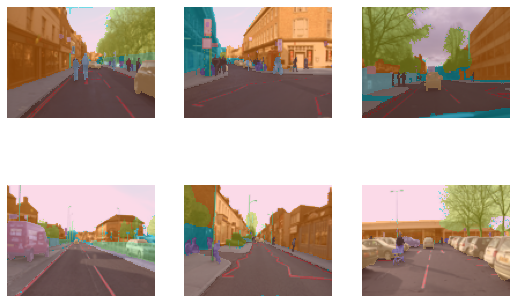

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
learn = unet_learner(dls, resnet34)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [ ]:
learn.fine_tune(6)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,time
0,3.300590,2.593196,00:48


epoch,train_loss,valid_loss,time
0,1.965989,1.369859,03:49
1,1.697363,1.246539,04:29
2,1.546322,1.082998,01:50
3,1.420143,1.004847,01:08
4,1.306798,0.923030,01:56
5,1.215737,0.887505,01:12


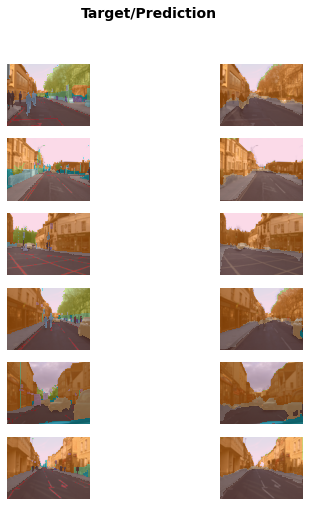

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

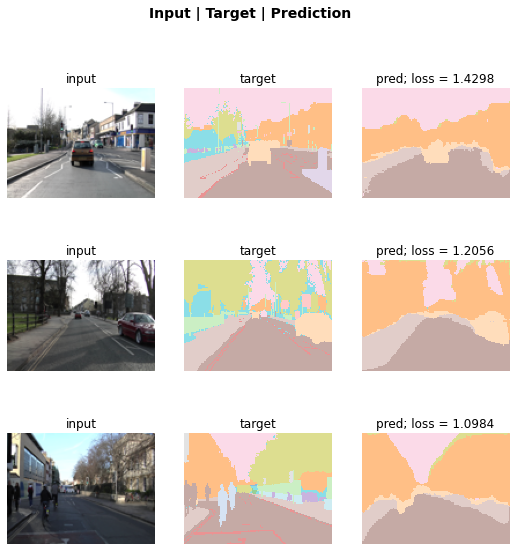

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [ ]:
dls = camvid.dataloaders(path/"images", path=path, bs=8)

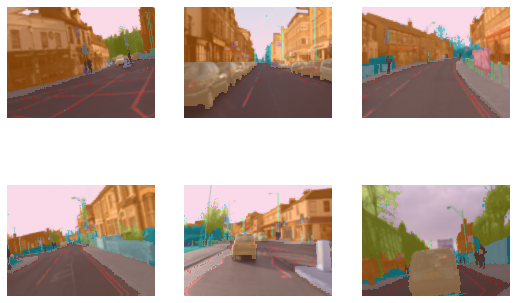

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
learn.save('mini_train')

Path('/tmp/fastai/camvid_tiny/models/mini_train.pth')

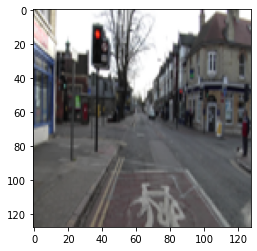

In [ ]:
plt.imshow(cam_img().resize((128,128)))

In [ ]:
from misas.core import *
from misas.core import default_cmap

In [ ]:
learn.prepareSize = lambda item: item.resize((128,128))

In [ ]:
class Fastai_model:
    def __init__(self, learner):
        self.trainedModel = learner
        self.resize128 = lambda x: x.resize ((128,128))
        self.trainedModel.remove_cbs(ProgressCallback)

        
    def prepareSize(self, item):
        return self.resize128(item)
    
    def predict(self, image):
        image = PILImage.create(np.array(image))
        output = self.trainedModel.predict(image)
        output = PILImage.create(output [0])
        output = Image.fromarray(np.array(output)) #mode="I"
        return output


In [ ]:
Cam_vid = Fastai_model(learn.load("/tmp/fastai/camvid_tiny/models/mini_train"))

  0%|          | 0/6 [00:00<?, ?it/s]

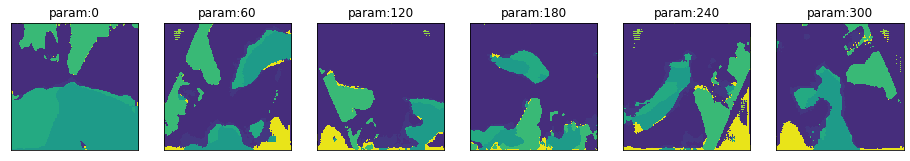

In [ ]:
plot_series(get_rotation_series(cam_img(), Cam_vid), vmax=31, vmin=0)

  0%|          | 0/10 [00:00<?, ?it/s]

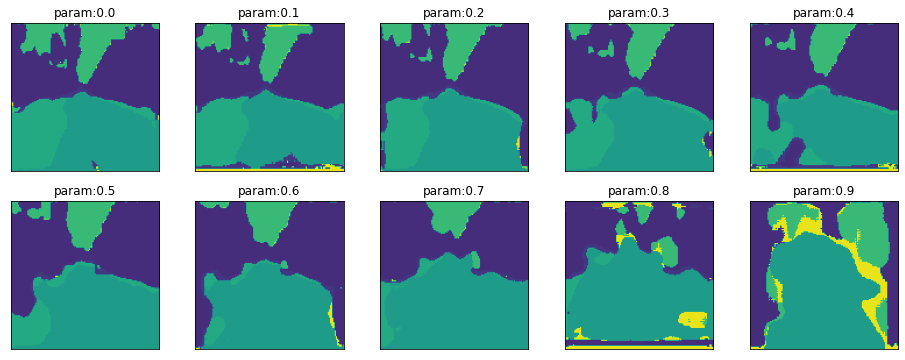

In [ ]:
plot_series(get_zoom_series(cam_img(), Cam_vid), vmax=31, vmin=0, nrow=2)

In [ ]:
found_classes = np.unique(np.array(Cam_vid.predict(cam_img())))

In [ ]:
codes[found_classes]

array(['Building', 'Car', 'Road', 'Sidewalk', 'Sky', 'Tree', 'Void'],
      dtype='<U17')

In [ ]:
result = eval_rotation_series(cam_img(),mask(),Cam_vid,components=codes)

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
result[np.append(codes[found_classes],'deg')]

,Building,Car,Road,Sidewalk,Sky,Tree,Void,deg
0,0.810482,0.079511,0.791803,0.815281,0.818355,0.055394,0.000000,0
1,0.726063,0.043046,0.788930,0.773045,0.799506,0.003067,0.006231,5
2,0.690185,0.056980,0.794970,0.744882,0.786495,0.006462,0.004566,10
3,0.632864,0.048077,0.739186,0.631579,0.780456,0.016000,0.000000,15
4,0.594259,0.033844,0.642071,0.534664,0.771515,0.006590,0.002941,20
...,...,...,...,...,...,...,...,...
67,0.629882,0.036929,0.644703,0.290335,0.732143,0.064715,0.000000,335
68,0.647864,0.033764,0.709808,0.604734,0.725600,0.096724,0.002497,340
69,0.678219,0.023965,0.741935,0.730749,0.722181,0.064122,0.002475,345
70,0.706984,0.032922,0.767617,0.789928,0.745191,0.051908,0.000000,350


Text(0, 0.5, 'dice')

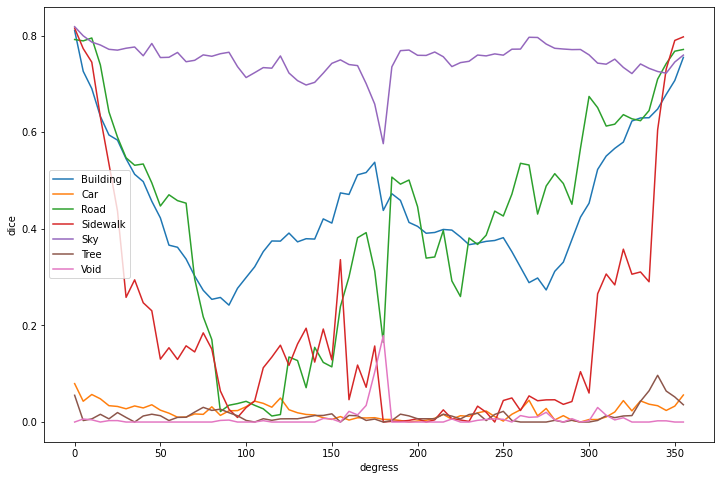

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8))
for i in codes[found_classes]:
    ax.plot(result['deg'], result[i], label=i)
ax.legend()
ax.set_xlabel('degress')
ax.set_ylabel('dice')